This example mirrors `example_reconstruction_4d.ipynb` but uses a normalizing flow as the generative model.

We start by training a NN generative model. The purpose of this step is to check 
that a solution exists and to compare to the regularized solutions later on. 
This step also estimates the 6 x 6 covariance matrix, which allows us to define
the generative model in a normalized space without linear correlations between 
variables. The covariance matrix is also useful for defining a prior 
distribution over the phase space coordiantes.

We then train a normalizing flow to maximize the entropy of the model 
distribution :math:`p_{\theta}(x)` relative to a Gaussian prior :math:`q(x)`, 
where :math:`\theta` represents the model parameters. We encourage consistency 
with the data using a soft penalty method. For an increasing series of penalty
parameters :math:`\lambda`, we minimize the following regularized loss function:

.. math:: L(theta) = -S(\theta) + \lambda * D(\theta),

where :math:`S(\theta)` is the entropy and :math:`D(\theta)` is the mean 
absolute prediction error.

# 4D phase space reconstruction using normalizing flow

This example mirrors `example_reconstruction_4d.ipynb` but uses a [normalizing flow](https://arxiv.org/abs/1912.02762) as the generative model.

We start by training the standard NN generative model. The purpose of this step is to check that a solution exists and to compare to the regularized solutions later on. This step also estimates the 6 x 6 covariance matrix $\Sigma = \langle x x^T \rangle$, which allows us to define the generative model in a normalized space without linear correlations between variables. The covariance matrix is also useful for defining a prior distribution over the phase space coordiantes.

We then train a normalizing flow to maximize the entropy of the model distribution $p_\theta(x)$ relative to a Gaussian prior $q(x) = \mathcal{N}(0, \Sigma)$, where $\theta$ represents the model parameters. We encourage consistency with the data using a soft penalty method: for an increasing series of penalty
parameters $\lambda$, we minimize the following regularized loss:

$$
L(\theta) = -S(\theta) + \lambda D(\theta),
$$
where $S(\theta)$ is the entropy of the model distribution,

$$
S(\theta) = S[p(x), q(x)] = -\int p(x) \log \left( \frac{p(x)}{q(x)} \right) dx,
$$

and $D(\theta)$ is a measure of discrepancy between predicted and measured data. The purpose of this example is to verify a smooth transition from the Gaussian prior as $\lambda$ increases.

In [1]:
import argparse
import os
import pathlib
import time

import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

from gpsr.beams import NNParticleBeamGenerator 
from gpsr.beams import NSF
from gpsr.beams import EntropyBeamGenerator
from gpsr.beams import GaussianPrior
from gpsr.losses import mae_loss
from gpsr.losses import normalize_images
from gpsr.modeling import GPSR
from gpsr.modeling import GPSRQuadScanLattice
from gpsr.modeling import EntropyGPSR
from gpsr.datasets import QuadScanDataset
from gpsr.datasets import split_dataset
from gpsr.train import LitGPSR
from gpsr.train import EntropyLitGPSR

## Setup

In [2]:
ndim = 6

In [3]:
args = argparse.Namespace(
    data_split=4,
    flow_transforms=3,
    flow_width=64,
    flow_depth=3,
    prior_scale=1.1,
    nsamp=20_000,
    iters=250,
    iters_pre=500,
    epochs=8,
    lr=0.001,
    penalty_min=1000.0,
    penalty_max=None,
    penalty_step=1000.0,
    penalty_scale=2.0,
    loss_pred_rtol=0.01,
    plot_nsamp=256_000,
    plot_bins=50,
    plot_smooth=0.0,
    show=True
)

## Data

In [4]:
filename =  "example_data/example_datasets/reconstruction_4D.dset"
dset = torch.load(filename, weights_only=False)

train_k_ids = np.arange(0, len(dset.parameters), args.data_split)
train_dset, test_dset = split_dataset(dset, train_k_ids)

## Lattice

In [5]:
p0c = 43.36e+06  # reference particle momentum [eV/c]
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, screen=train_dset.screen)

## Train NN model

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/Users/46h/miniconda3/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/46h/miniconda3/envs/gpsr/lib/python3

Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=500` reached.


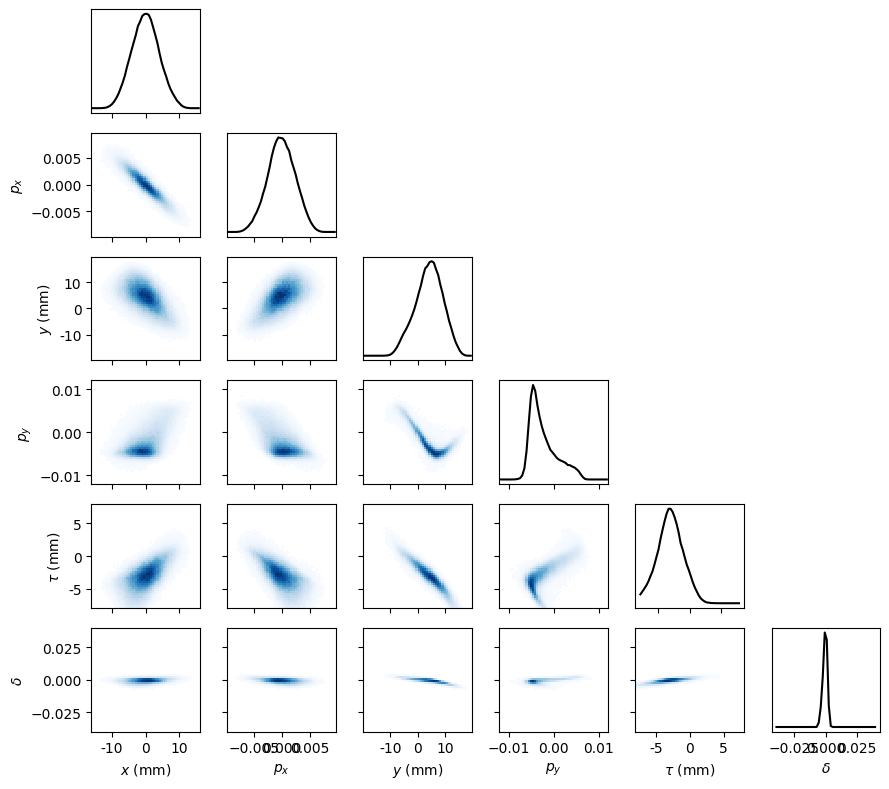

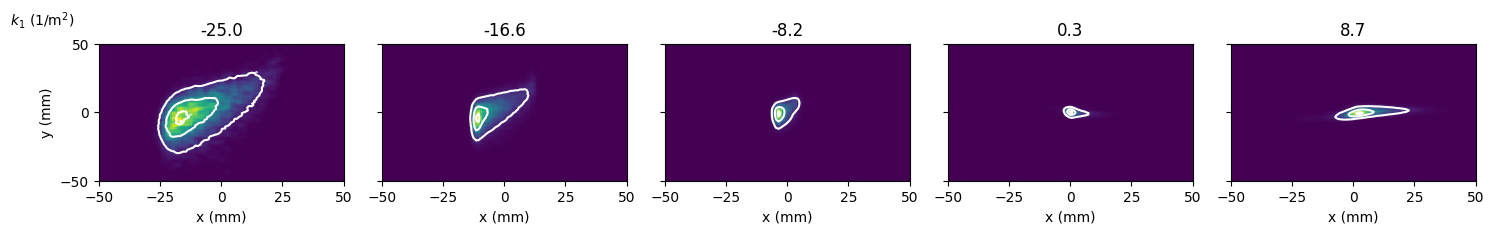

In [6]:
beam_generator = NNParticleBeamGenerator(args.nsamp, p0c)
gpsr_model = GPSR(beam_generator, gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10)

litgpsr = LitGPSR(gpsr_model)
trainer = lightning.Trainer(limit_train_batches=100, max_epochs=args.iters_pre)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

litgpsr.gpsr_model.eval()
with torch.no_grad():
    litgpsr.gpsr_model.beam_generator.set_base_particles(args.plot_nsamp)
    beam = litgpsr.gpsr_model.beam_generator()

    # Compute covariance matrix (ignore longitudinal coordinates)
    x = beam.particles[:, 0:6].detach().clone()
    x[:, 4] = torch.randn(x.shape[0]) * 0.002
    x[:, 5] = torch.randn(x.shape[0]) * 0.01
    cov_matrix = torch.cov(x.T)

    # Compute plotting limits
    xmax = 4.0 * torch.std(x, axis=0)
    limits = [(-float(_xmax), float(_xmax)) for _xmax in xmax]

    # Plot beam
    fig, axs = beam.plot_distribution(
        bins=args.plot_bins,
        bin_ranges=limits,
        plot_2d_kws=dict(
            histogram_smoothing=args.plot_smooth,
            pcolormesh_kws=dict(cmap="Blues"),
        ),
    )
    fig.set_size_inches(9.0, 8.0)
    fig.tight_layout()
    if args.show:
        plt.show()

    # Make predictions
    predictions = litgpsr.gpsr_model(train_dset.parameters)
    pred_dset = QuadScanDataset(train_dset.parameters, predictions[0].detach(), train_dset.screen)

    # Plot predictions
    fig, ax = train_dset.plot_data(overlay_data=pred_dset, overlay_kwargs=dict(colors="white", cmap=None))
    fig.set_size_inches(len(train_k_ids) * 3.0, 2.5)
    fig.tight_layout()
    if args.show:
        plt.show()

## Create normalizing flow

In [7]:
gen_model = NSF(
    ndim=ndim, 
    cov_matrix=cov_matrix, 
    transforms=args.flow_transforms, 
    hidden_units=args.flow_width, 
    hidden_layers=args.flow_depth,
)

prior_loc = torch.zeros(ndim)
prior_cov = cov_matrix * args.prior_scale**2
prior = GaussianPrior(prior_loc, prior_cov)

beam_generator = EntropyBeamGenerator(
    gen_model=gen_model, 
    prior=prior, 
    n_particles=args.nsamp,
    energy=p0c,
)

gpsr_model = EntropyGPSR(beam_generator=beam_generator, lattice=gpsr_lattice)

## Train normalizing flow

In [8]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10)

litgpsr = EntropyLitGPSR(gpsr_model, lr=args.lr, penalty=args.penalty_min)
trainer = lightning.Trainer(limit_train_batches=100, max_epochs=args.iters)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | gpsr_model | EntropyGPSR | 53.2 K | train
---------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


EPOCH=0
PENALTY=1000.0


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=250` reached.


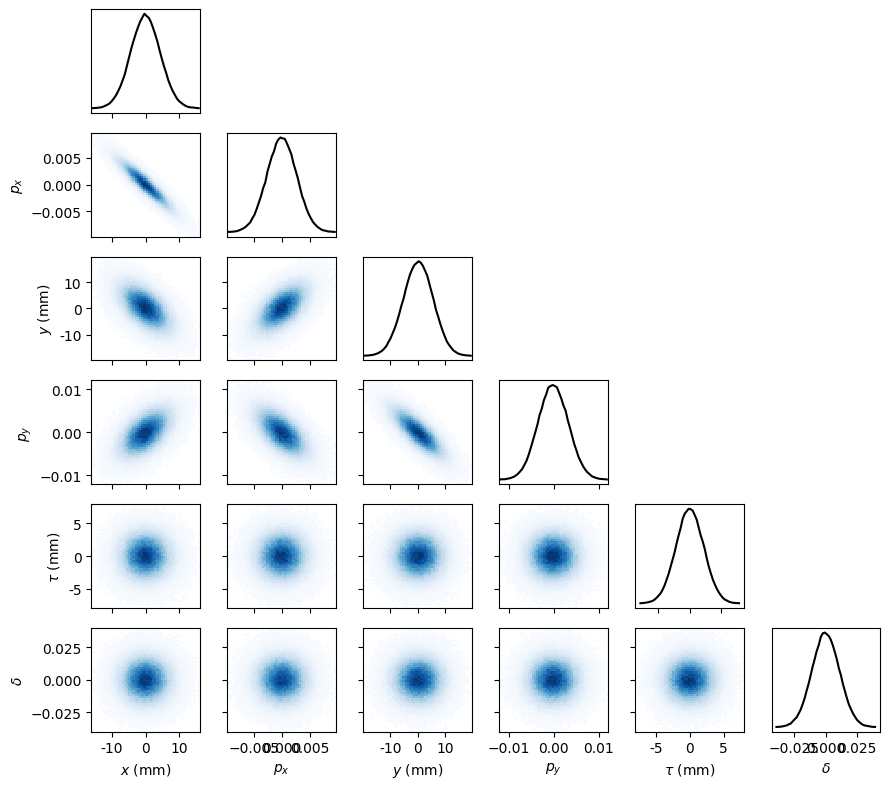

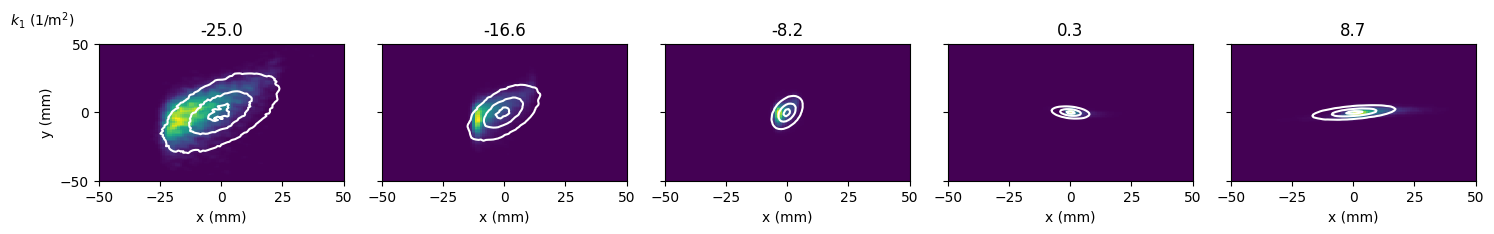

/Users/46h/miniconda3/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/46h/repo/gpsr/docs/examples/lightning_logs/version_6/checkpoints exists and is not empty.

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | gpsr_model | EntropyGPSR | 53.2 K | train
---------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


LOSS (PRED) = 1.359e-04
LOSS (PRED) REL CHANGE = -1.000e+00
EPOCH=1
PENALTY=3000.0


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=500` reached.


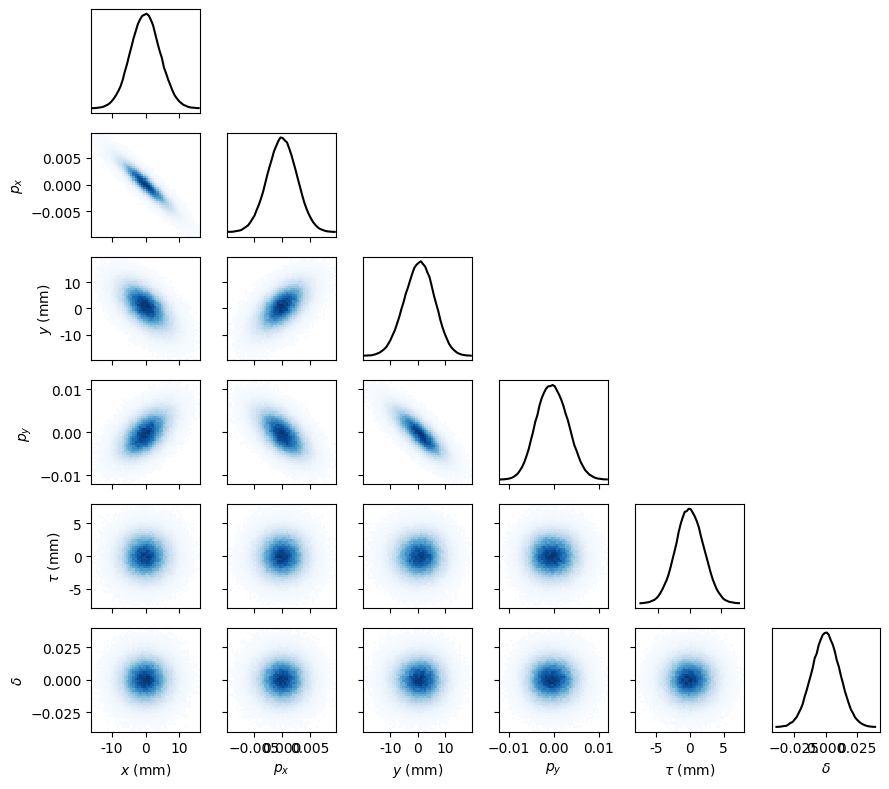

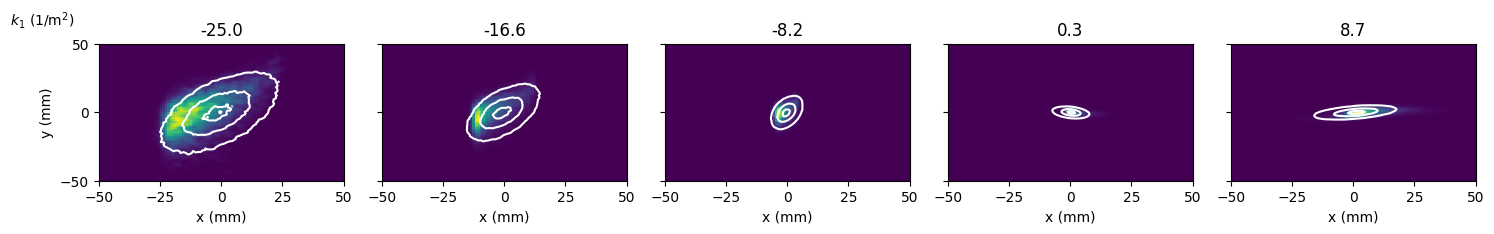


  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | gpsr_model | EntropyGPSR | 53.2 K | train
---------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


LOSS (PRED) = 1.339e-04
LOSS (PRED) REL CHANGE = -1.467e-02
EPOCH=2
PENALTY=7000.0


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=750` reached.


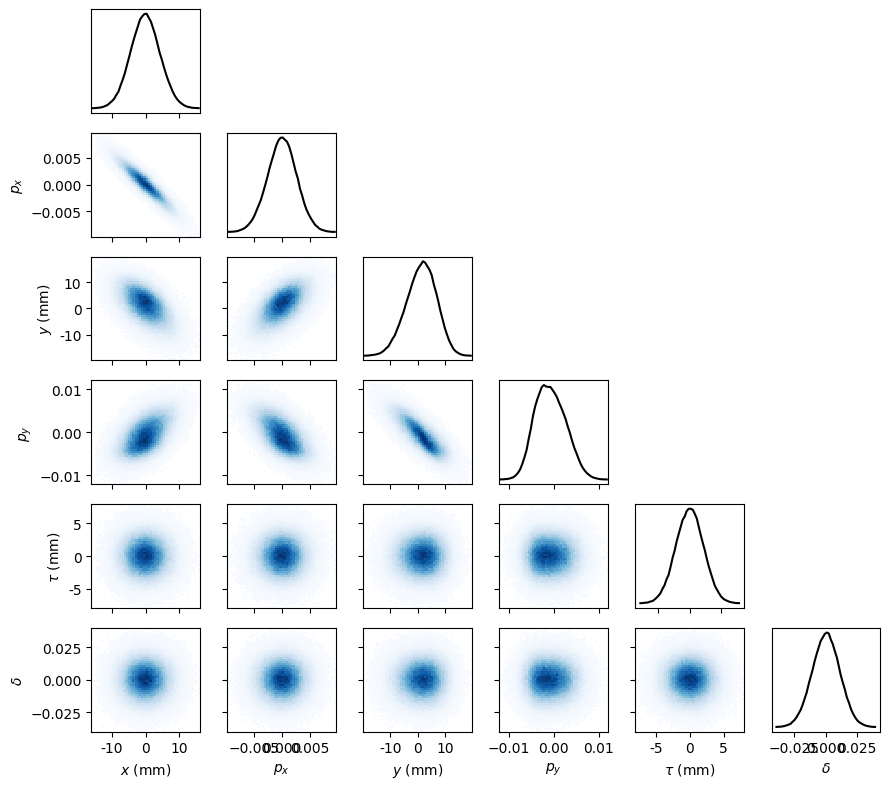

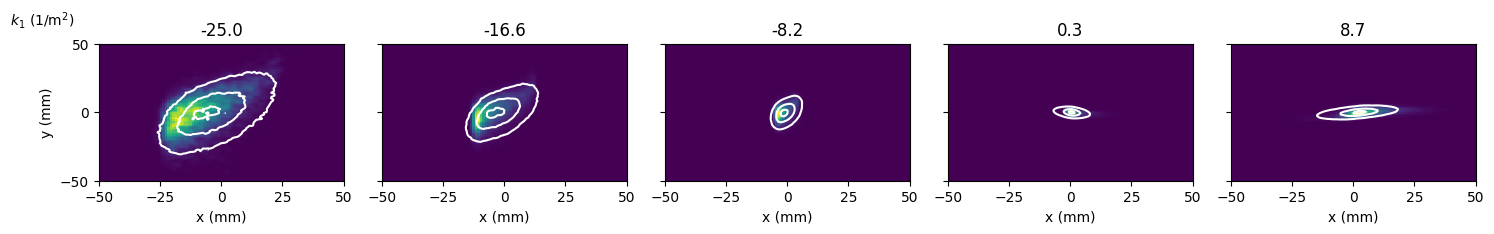


  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | gpsr_model | EntropyGPSR | 53.2 K | train
---------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


LOSS (PRED) = 1.309e-04
LOSS (PRED) REL CHANGE = -2.247e-02
EPOCH=3
PENALTY=15000.0


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1000` reached.


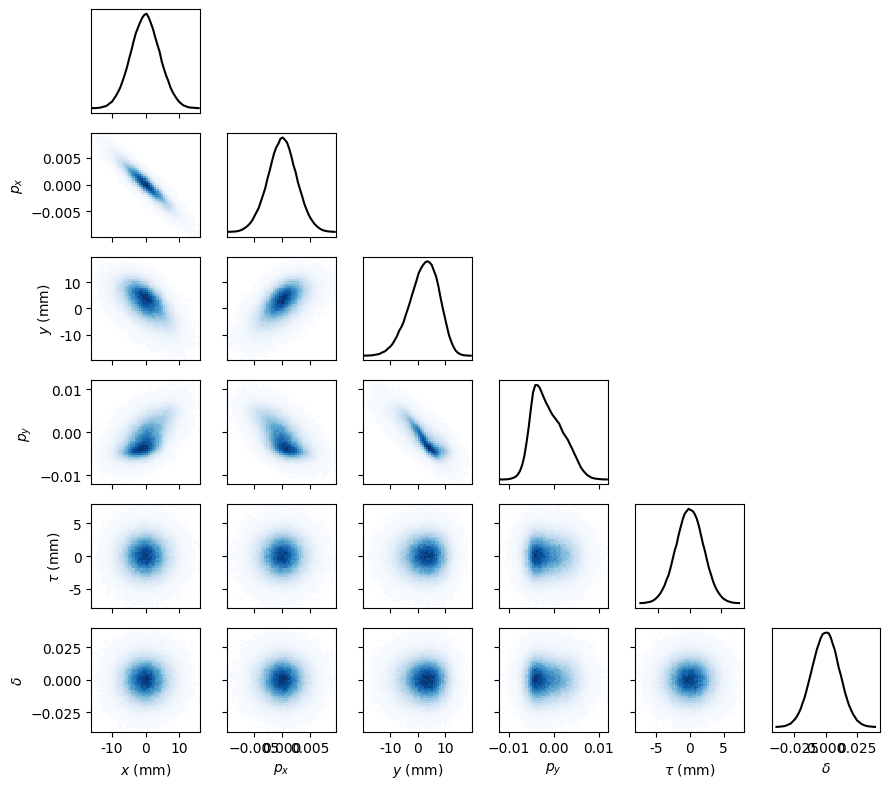

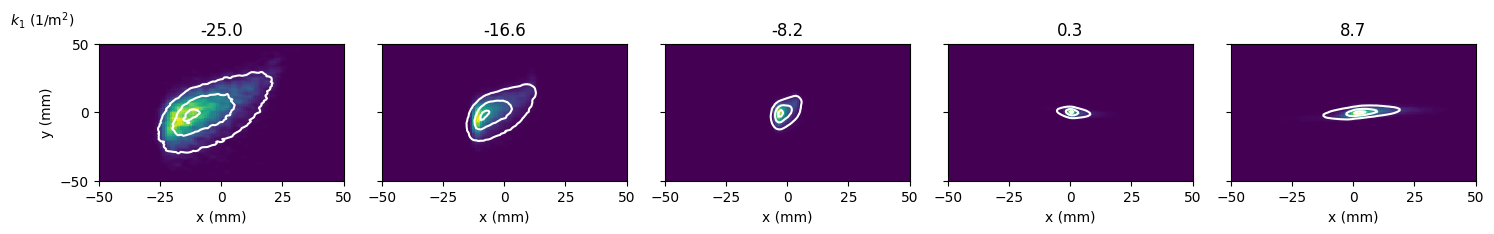


  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | gpsr_model | EntropyGPSR | 53.2 K | train
---------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


LOSS (PRED) = 1.269e-04
LOSS (PRED) REL CHANGE = -3.039e-02
EPOCH=4
PENALTY=31000.0


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1250` reached.


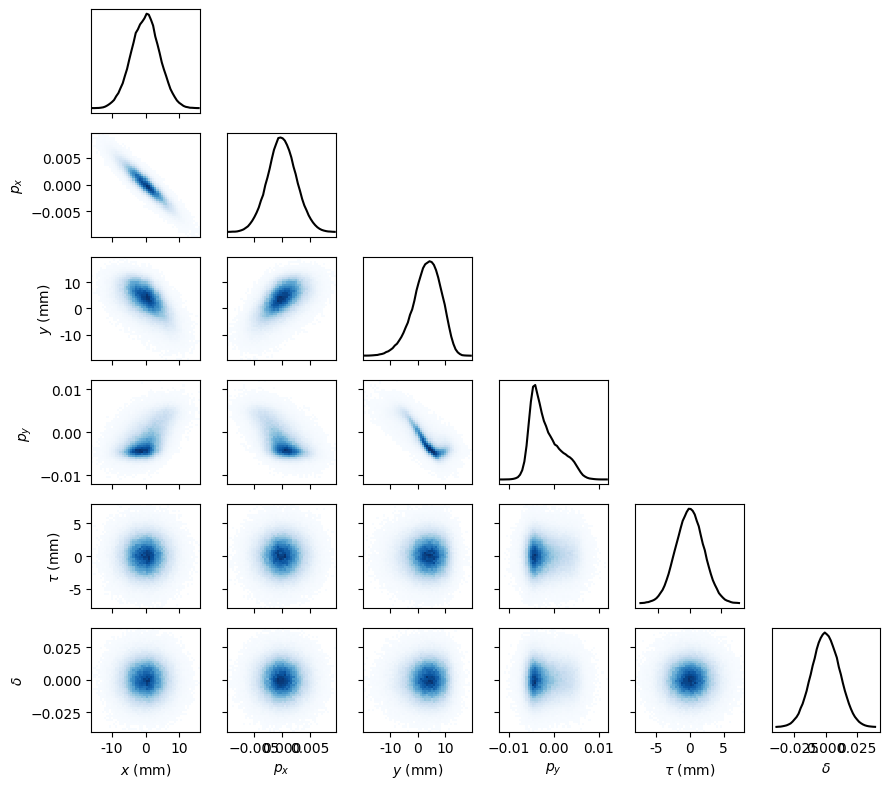

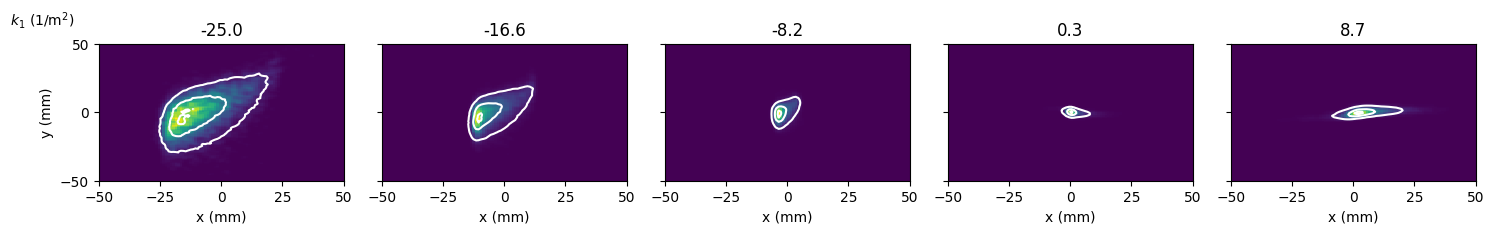

LOSS (PRED) = 1.256e-04
LOSS (PRED) REL CHANGE = -9.943e-03
Stopping early


In [9]:
loss_pred_old = 1.00e+14

for epoch in range(args.epochs):
    # Train
    print("EPOCH={}".format(epoch))
    print("PENALTY={}".format(litgpsr.penalty))

    trainer.fit(model=litgpsr, train_dataloaders=train_loader)
    trainer.fit_loop.max_epochs += args.iters

    # Plot
    with torch.no_grad():
        # Increase particle count
        litgpsr.gpsr_model.eval()
        litgpsr.gpsr_model.beam_generator.set_base_particles(args.plot_nsamp)

        # Generate beam and predictions
        beam, entropy, predictions = litgpsr.gpsr_model(train_dset.parameters)
        pred_dset = QuadScanDataset(train_dset.parameters, predictions[0].detach(), train_dset.screen)

        # Plot beam (corner plot)
        fig, axs = beam.plot_distribution(
            bins=args.plot_bins,
            bin_ranges=limits,
            plot_2d_kws=dict(
                histogram_smoothing=args.plot_smooth,
                pcolormesh_kws=dict(cmap="Blues"),
            ),
        )
        fig.set_size_inches(9.0, 8.0)
        fig.tight_layout()
        if args.show:
            plt.show()

        # Plot predictions
        fig, ax = train_dset.plot_data(overlay_data=pred_dset, overlay_kwargs=dict(colors="white", cmap=None))
        fig.set_size_inches(len(train_k_ids) * 3.0, 2.5)
        fig.tight_layout()
        if args.show:
            plt.show()

        # Reset particle count
        litgpsr.gpsr_model.beam_generator.set_base_particles(args.nsamp)
        litgpsr.gpsr_model.train()

    # Evaluate/update loss function
    with torch.no_grad():
        litgpsr.gpsr_model.eval()
        litgpsr.gpsr_model.beam_generator.set_base_particles(args.plot_nsamp)

        # Compute losses
        parameters = train_dset.parameters
        y_meas = train_dset.observations[0]
        beam, entropy, y_pred = litgpsr.gpsr_model(parameters)
        y_meas = [normalize_images(y) for y in y_meas]
        y_pred = [normalize_images(y) for y in y_pred]
        loss_pred = [mae_loss(ym, yp) for ym, yp in zip(y_meas, y_pred)]
        loss_pred = sum(loss_pred) / len(loss_pred)

        # Early stopping
        loss_pred_rel = ((loss_pred - loss_pred_old) / loss_pred_old)
        loss_pred_old = loss_pred
        
        print("LOSS (PRED) = {:0.3e}".format(loss_pred))
        print("LOSS (PRED) REL CHANGE = {:0.3e}".format(loss_pred_rel))

        if (epoch > 2) and (loss_pred_rel > -args.loss_pred_rtol):
            print("Stopping early")
            break

        litgpsr.gpsr_model.beam_generator.set_base_particles(args.nsamp)
        litgpsr.gpsr_model.train()

    # Update penalty parameter
    litgpsr.penalty *= args.penalty_scale
    litgpsr.penalty += args.penalty_step
    if args.penalty_max is not None:
        litgpsr.penalty = min(litgpsr.penalty, args.penalty_max)

## Evaluation

Check that we can generate samples and evaluate the probability density of the model distribution. Here we show a 2D slice $\rho(x, p_x | y = p_y = z = p_z = 0)$. Note that the samples will only be approximate due to finite statistics. 

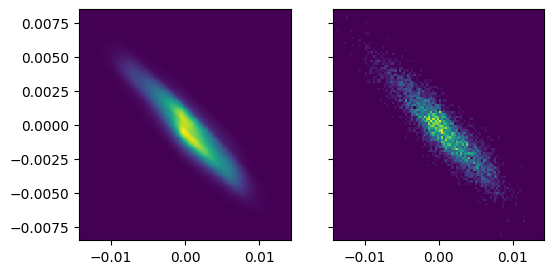

In [18]:
axis = (0, 1)

gen_model.eval()
with torch.no_grad():    
    # Set coordinate limits
    x = gen_model.sample(10_000)
    x = x.detach()
    xmax = 3.5 * torch.std(x, axis=0)
    xlim = list(zip(-xmax, xmax))

    # Define grid over two-dimensional axis
    grid_res = 256
    grid_shape = (grid_res, grid_res)
    grid_coords = [torch.linspace(xlim[i][0], xlim[i][1], grid_res) for i in axis]
    grid_points = torch.stack([c.ravel() for c in torch.meshgrid(*grid_coords, indexing="ij")], axis=-1)

    # Evaluate probability density on grid
    grid_points = torch.stack([c.ravel() for c in torch.meshgrid(*grid_coords, indexing="ij")], axis=-1)
    grid_points_all = torch.zeros((grid_points.shape[0], 6))
    for i in range(len(axis)):
        grid_points_all[:, axis[i]] = grid_points[:, i]
    
    log_prob = gen_model.log_prob(grid_points_all)
    log_prob = log_prob - torch.max(log_prob)
    log_prob = log_prob.reshape(grid_shape)
    prob = torch.exp(log_prob)

    # Sample particles ~ in slice
    x_slice_total = []
    for _ in range(1):
        x = gen_model.sample(1_000_000)
        slice_width = 0.1 * xmax
        idx = torch.ones(x.shape[0])
        for i in range(ndim):
            if not (i in axis):            
                idx = torch.logical_and(idx, torch.abs(x[:, i]) < slice_width[i])
        x_slice = x[idx, :]
        x_slice_total.append(x_slice.clone())
            
    fig, axs = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True)
    axs[0].pcolormesh(grid_coords[0], grid_coords[1], prob.T, vmax=1.0, vmin=0.0)
    axs[1].hist2d(x_slice[:, axis[0]], x_slice[:, axis[1]], bins=100, range=[xlim[i] for i in axis])
    plt.show()